## MLflow with Optuna: Hyperparameter Optimization and Tracking

A critical part of building production-grade models is ensuring that a given model's parameters are selected to create the best inference set possible. However, the sheer number of combinations and their resultant metrics can become overwhelming to track manually. That's where tools like MLflow and Optuna come into play.

### Objective: 
In this notebook, you'll learn how to integrate MLflow with Optuna for hyperparameter optimization. We'll guide you through the process of:

* Setting up your environment with MLflow tracking.
* Generating our training and evaluation data sets.
* Defining a partial function that fits a machine learning model.
* Using Optuna for hyperparameter tuning.
* Leveraging child runs within MLflow to keep track of each iteration during the hyperparameter tuning process.

### Why Optuna?
Optuna is an open-source hyperparameter optimization framework in Python. It provides an efficient approach to searching over hyperparameters, incorporating the latest research and techniques. With its integration into MLflow, every trial can be systematically recorded.

### Child Runs in MLflow:
One of the core features we will be emphasizing is the concept of 'child runs' in MLflow. When performing hyperparameter tuning, each iteration (or trial) in Optuna can be considered a 'child run'. This allows us to group all the runs under one primary 'parent run', ensuring that the MLflow UI remains organized and interpretable. Each child run will track the specific hyperparameters used and the resulting metrics, providing a consolidated view of the entire optimization process.

### What's Ahead?

**Data Preparation**: We'll start by loading and preprocessing our dataset.

**Model Definition**: Defining a machine learning model that we aim to optimize.

**Optuna Study**: Setting up an Optuna study to find the best hyperparameters for our model.

**MLflow Integration**: Tracking each Optuna trial as a child run in MLflow.

**Analysis**: Reviewing the tracked results in the MLflow UI.

By the end of this notebook, you'll have hands-on experience in setting up an advanced hyperparameter tuning workflow, emphasizing best practices and clean organization using MLflow and Optuna. 

**Let's dive in!**

In [1]:
import math
from datetime import datetime, timedelta

import numpy as np
import optuna
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import mlflow

### Configure the tracking server uri

Depending on where you are running this notebook, your configuration may vary for how you initialize the interface with the MLflow Tracking Server. 

For this example, we're using a locally running tracking server, but other options are available (The easiest is to use the free managed service within [Databricks Community Edition](https://community.cloud.databricks.com/)). 

Please see [the guide to running notebooks here](https://www.mlflow.org/docs/latest/getting-started/running-notebooks/index.html) for more information on setting the tracking server uri and configuring access to either managed or self-managed MLflow tracking servers.

In [2]:
# NOTE: review the links mentioned above for guidance on connecting to a managed tracking server, such as the free Databricks Community Edition

mlflow.set_tracking_uri("http://localhost:8080")

### Generate our synthetic training data

If you've followed along with the introductory tutorial "Logging your first model with MLflow", then you're familiar with the apples sales data generator that we created for that tutorial. 

Here, we're expanding upon the data to create a slightly more complex dataset that should have improved correlation effects between the features and the target variable (the demand). 

In [3]:
def generate_apple_sales_data_with_promo_adjustment(
    base_demand: int = 1000,
    n_rows: int = 5000,
    competitor_price_effect: float = -50.0,
):
    """
    Generates a synthetic dataset for predicting apple sales demand with multiple
    influencing factors.

    This function creates a pandas DataFrame with features relevant to apple sales.
    The features include date, average_temperature, rainfall, weekend flag, holiday flag,
    promotional flag, price_per_kg, competitor's price, marketing intensity, stock availability,
    and the previous day's demand. The target variable, 'demand', is generated based on a
    combination of these features with some added noise.

    Args:
        base_demand (int, optional): Base demand for apples. Defaults to 1000.
        n_rows (int, optional): Number of rows (days) of data to generate. Defaults to 5000.
        competitor_price_effect (float, optional): Effect of competitor's price being lower
                                                   on our sales. Defaults to -50.

    Returns:
        pd.DataFrame: DataFrame with features and target variable for apple sales prediction.

    Example:
        >>> df = generate_apple_sales_data_with_promo_adjustment(base_demand=1200, n_rows=6000)
        >>> df.head()
    """

    # Set seed for reproducibility
    np.random.seed(9999)

    # Create date range
    dates = [datetime.now() - timedelta(days=i) for i in range(n_rows)]
    dates.reverse()

    # Generate features
    df = pd.DataFrame(
        {
            "date": dates,
            "average_temperature": np.random.uniform(10, 35, n_rows),
            "rainfall": np.random.exponential(5, n_rows),
            "weekend": [(date.weekday() >= 5) * 1 for date in dates],
            "holiday": np.random.choice([0, 1], n_rows, p=[0.97, 0.03]),
            "price_per_kg": np.random.uniform(0.5, 3, n_rows),
            "month": [date.month for date in dates],
        }
    )

    # Introduce inflation over time (years)
    df["inflation_multiplier"] = 1 + (df["date"].dt.year - df["date"].dt.year.min()) * 0.03

    # Incorporate seasonality due to apple harvests
    df["harvest_effect"] = np.sin(2 * np.pi * (df["month"] - 3) / 12) + np.sin(
        2 * np.pi * (df["month"] - 9) / 12
    )

    # Modify the price_per_kg based on harvest effect
    df["price_per_kg"] = df["price_per_kg"] - df["harvest_effect"] * 0.5

    # Adjust promo periods to coincide with periods lagging peak harvest by 1 month
    peak_months = [4, 10]  # months following the peak availability
    df["promo"] = np.where(
        df["month"].isin(peak_months),
        1,
        np.random.choice([0, 1], n_rows, p=[0.85, 0.15]),
    )

    # Generate target variable based on features
    base_price_effect = -df["price_per_kg"] * 50
    seasonality_effect = df["harvest_effect"] * 50
    promo_effect = df["promo"] * 200

    df["demand"] = (
        base_demand
        + base_price_effect
        + seasonality_effect
        + promo_effect
        + df["weekend"] * 300
        + np.random.normal(0, 50, n_rows)
    ) * df["inflation_multiplier"]  # adding random noise

    # Add previous day's demand
    df["previous_days_demand"] = df["demand"].shift(1)
    df["previous_days_demand"].fillna(method="bfill", inplace=True)  # fill the first row

    # Introduce competitor pricing
    df["competitor_price_per_kg"] = np.random.uniform(0.5, 3, n_rows)
    df["competitor_price_effect"] = (
        df["competitor_price_per_kg"] < df["price_per_kg"]
    ) * competitor_price_effect

    # Stock availability based on past sales price (3 days lag with logarithmic decay)
    log_decay = -np.log(df["price_per_kg"].shift(3) + 1) + 2
    df["stock_available"] = np.clip(log_decay, 0.7, 1)

    # Marketing intensity based on stock availability
    # Identify where stock is above threshold
    high_stock_indices = df[df["stock_available"] > 0.95].index

    # For each high stock day, increase marketing intensity for the next week
    for idx in high_stock_indices:
        df.loc[idx : min(idx + 7, n_rows - 1), "marketing_intensity"] = np.random.uniform(0.7, 1)

    # If the marketing_intensity column already has values, this will preserve them;
    #  if not, it sets default values
    fill_values = pd.Series(np.random.uniform(0, 0.5, n_rows), index=df.index)
    df["marketing_intensity"].fillna(fill_values, inplace=True)

    # Adjust demand with new factors
    df["demand"] = df["demand"] + df["competitor_price_effect"] + df["marketing_intensity"]

    # Drop temporary columns
    df.drop(
        columns=[
            "inflation_multiplier",
            "harvest_effect",
            "month",
            "competitor_price_effect",
            "stock_available",
        ],
        inplace=True,
    )

    return df

In [4]:
df = generate_apple_sales_data_with_promo_adjustment(base_demand=1_000, n_rows=5000)
df

,date,average_temperature,rainfall,weekend,holiday,price_per_kg,promo,demand,previous_days_demand,competitor_price_per_kg,marketing_intensity
0,2010-01-14 11:52:20.662955,30.584727,1.199291,0,0,1.726258,0,851.375336,851.276659,1.935346,0.098677
1,2010-01-15 11:52:20.662954,15.465069,1.037626,0,0,0.576471,0,906.855943,851.276659,2.344720,0.019318
2,2010-01-16 11:52:20.662954,10.786525,5.656089,1,0,2.513328,0,1108.304909,906.836626,0.998803,0.409485
3,2010-01-17 11:52:20.662953,23.648154,12.030937,1,0,1.839225,0,1099.833810,1157.895424,0.761740,0.872803
4,2010-01-18 11:52:20.662952,13.861391,4.303812,0,0,1.531772,0,983.949061,1148.961007,2.123436,0.820779
...,...,...,...,...,...,...,...,...,...,...,...
4995,2023-09-18 11:52:20.659592,21.643051,3.821656,0,0,2.391010,0,1140.210762,1563.064082,1.504432,0.756489
4996,2023-09-19 11:52:20.659591,13.808813,1.080603,0,1,0.898693,0,1285.149505,1189.454273,1.343586,0.742145
4997,2023-09-20 11:52:20.659590,11.698227,1.911000,0,0,2.839860,0,965.171368,1284.407359,2.771896,0.742145
4998,2023-09-21 11:52:20.659589,18.052081,1.000521,0,0,1.188440,0,1368.369501,1014.429223,2.564075,0.742145


### Examining Feature-Target Correlations

Before delving into the model building process, it's essential to understand the relationships between our features and the target variable. The upcoming function will display a plot indicating the correlation coefficient for each feature in relation to the target. Here's why this step is crucial:

1. **Avoiding Data Leakage**: We must ensure that no feature perfectly correlates with the target (a correlation coefficient of 1.0). If such a correlation exists, it's a sign that our dataset might be "leaking" information about the target. Using such data for hyperparameter tuning would mislead the model, as it could easily achieve a perfect score without genuinely learning the underlying patterns.

2. **Ensuring Meaningful Relationships**: Ideally, our features should have some degree of correlation with the target. If all features have correlation coefficients close to zero, it suggests a weak linear relationship. Although this doesn't automatically render the features useless, it does introduce challenges:
    * *Predictive Power*: The model might struggle to make accurate predictions.
    * *Overfitting Risk*: With weak correlations, there's a heightened risk of the model fitting to noise rather than genuine patterns, leading to overfitting.
    * *Complexity*: Demonstrating non-linear relationships or interactions between features would necessitate more intricate visualizations and evaluations.
3. **Auditing and Traceability**: Logging this correlation visualization with our main MLflow run ensures traceability. It provides a snapshot of the data characteristics at the time of the model training, which is invaluable for auditing and replicability purposes.

As we proceed, remember that while understanding correlations is a powerful tool, it's just one piece of the puzzle. Let's visualize these relationships to gain more insights!

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_correlation_with_demand(df, save_path=None):
    """
    Plots the correlation of each variable in the dataframe with the 'demand' column.

    Args:
    - df (pd.DataFrame): DataFrame containing the data, including a 'demand' column.
    - save_path (str, optional): Path to save the generated plot. If not specified, plot won't be saved.

    Returns:
    - None (Displays the plot on a Jupyter window)
    """

    # Compute correlations between all variables and 'demand'
    correlations = df.corr()["demand"].drop("demand").sort_values()

    # Generate a color palette from red to green
    colors = sns.diverging_palette(10, 130, as_cmap=True)
    color_mapped = correlations.map(colors)

    # Set Seaborn style
    sns.set_style(
        "whitegrid", {"axes.facecolor": "#c2c4c2", "grid.linewidth": 1.5}
    )  # Light grey background and thicker grid lines

    # Create bar plot
    fig = plt.figure(figsize=(12, 8))
    plt.barh(correlations.index, correlations.values, color=color_mapped)

    # Set labels and title with increased font size
    plt.title("Correlation with Demand", fontsize=18)
    plt.xlabel("Correlation Coefficient", fontsize=16)
    plt.ylabel("Variable", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis="x")

    plt.tight_layout()

    # Save the plot if save_path is specified
    if save_path:
        plt.savefig(save_path, format="png", dpi=600)

    # prevent matplotlib from displaying the chart every time we call this function
    plt.close(fig)

    return fig


# Test the function
correlation_plot = plot_correlation_with_demand(df, save_path="correlation_plot.png")

<Figure size 432x288 with 0 Axes>

#### Investigating Feature Correlation with the Target Variable

In the code above, we've intentionally disabled the automatic display of the plot generated by Matplotlib. During machine learning experimentation, it's often not useful to display figures directly within the notebook for several reasons. Instead, we aim to associate this plot with the results of an iterative experiment run. To achieve this, we'll save the plot to our MLflow tracking system. This provides us with a detailed record, linking the state of the dataset to the logged model, its parameters, and performance metrics.

##### Why Not Display Plots Directly in the Notebook?

Choosing not to display plots within the notebook is a deliberate decision, and the reasons are multiple. Some of the key points include:

- **Ephemerality of Notebooks**: Notebooks are inherently transient; they are not designed to be a permanent record of your work.
  
- **Risk of Obsolescence**: If you rerun portions of your notebook, the plot displayed could become outdated or misleading, posing a risk when interpreting results.
  
- **Loss of Previous State**: If you happen to rerun the entire notebook, the plot will be lost. While some plugins can recover previous cell states, setting this up can be cumbersome and time-consuming.

In contrast, logging the plot to MLflow ensures that we have a permanent, easily accessible record that correlates directly with other experiment data. This is invaluable for maintaining the integrity and reproducibility of your machine learning experiments.

##### Displaying the Plot for This Guide

For the purposes of this guide, we'll still take a moment to examine the plot. We can do this by explicitly calling the figure object we've returned from our function.


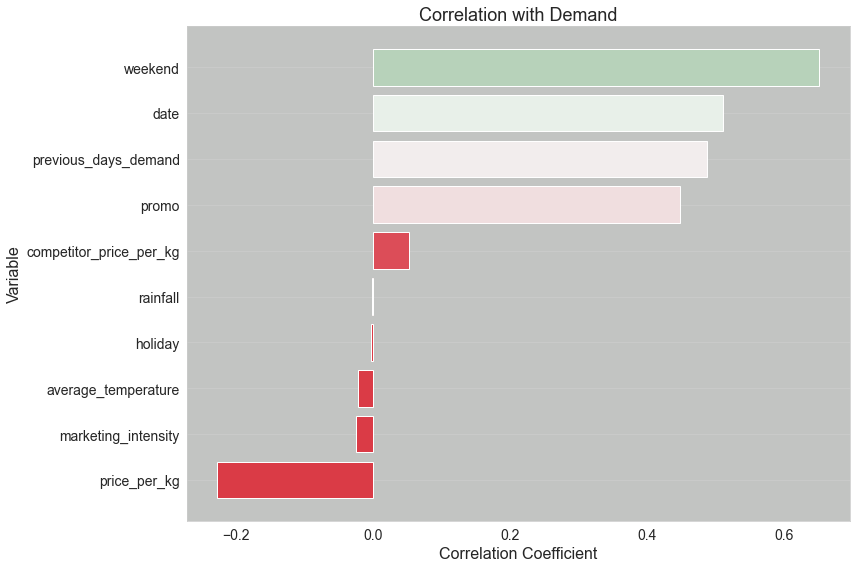

In [6]:
correlation_plot

#### Visualizing Model Residuals for Diagnostic Insights

The `plot_residuals` function serves to visualize the residuals—the differences between the model's predictions and the actual values in the validation set. Residual plots are crucial diagnostic tools in machine learning, as they can reveal patterns that suggest our model is either failing to capture some aspect of the data or that there's a systematic issue with the model itself.

##### Why Residual Plots?

Residual plots offer several advantages:

- **Identifying Bias**: If residuals show a trend (not centered around zero), it might indicate that your model is systematically over- or under-predicting the target variable.

- **Heteroskedasticity**: Varying spread of residuals across the range of the predicted values can indicate 'Heteroskedasticity,' which can violate assumptions in some modeling techniques.

- **Outliers**: Points far away from the zero line can be considered as outliers and might warrant further investigation.

##### Auto-saving the Plot

Just like with the correlation plot, this function allows you to save the residual plot to a specific path. This feature aligns with our broader strategy of logging important figures to MLflow for more effective model tracking and auditing.

##### Plot Structure

In the scatter plot, each point represents the residual for a specific observation in the validation set. The red horizontal line at zero serves as a reference, indicating where residuals would lie if the model's predictions were perfect.

For the sake of this guide, we will be generating this plot, but not examining it until later when we see it within the MLflow UI.


In [7]:
def plot_residuals(model, dvalid, valid_y, save_path=None):
    """
    Plots the residuals of the model predictions against the true values.

    Args:
    - model: The trained XGBoost model.
    - dvalid (xgb.DMatrix): The validation data in XGBoost DMatrix format.
    - valid_y (pd.Series): The true values for the validation set.
    - save_path (str, optional): Path to save the generated plot. If not specified, plot won't be saved.

    Returns:
    - None (Displays the residuals plot on a Jupyter window)
    """

    # Predict using the model
    preds = model.predict(dvalid)

    # Calculate residuals
    residuals = valid_y - preds

    # Set Seaborn style
    sns.set_style("whitegrid", {"axes.facecolor": "#c2c4c2", "grid.linewidth": 1.5})

    # Create scatter plot
    fig = plt.figure(figsize=(12, 8))
    plt.scatter(valid_y, residuals, color="blue", alpha=0.5)
    plt.axhline(y=0, color="r", linestyle="-")

    # Set labels, title and other plot properties
    plt.title("Residuals vs True Values", fontsize=18)
    plt.xlabel("True Values", fontsize=16)
    plt.ylabel("Residuals", fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis="y")

    plt.tight_layout()

    # Save the plot if save_path is specified
    if save_path:
        plt.savefig(save_path, format="png", dpi=600)

    # Show the plot
    plt.close(fig)

    return fig

#### Understanding Feature Importance with XGBoost

The `plot_feature_importance` function is designed to visualize the importance of each feature used in our XGBoost model. Understanding feature importance can offer critical insights into the model's decision-making process and can aid in feature selection, engineering, and interpretation.

##### Types of Feature Importance

XGBoost offers multiple ways to interpret feature importance. This function supports:

- **Weight**: Number of times a feature appears in a tree across the ensemble of trees (for `gblinear` booster).
- **Gain**: Average gain (or improvement to the model) of the feature when it is used in trees (for other booster types).

We automatically select the appropriate importance type based on the booster used in the XGBoost model.

##### Why Feature Importance Matters

Understanding feature importance offers several advantages:

- **Interpretability**: Knowing which features are most influential helps us understand the model better.
- **Feature Selection**: Unimportant features can potentially be dropped to simplify the model.
- **Domain Understanding**: Aligns the model's importance scale with domain-specific knowledge or intuition.

##### Saving and Accessing the Plot

This function returns a Matplotlib figure object that you can further manipulate or save. Like the previous plots, it is advisable to log this plot in MLflow for an immutable record of your model's interpretive characteristics.

##### Navigating the Plot

In the resulting plot, each bar represents a feature used in the model. The length of the bar corresponds to the feature's importance, as calculated by the selected importance type.

We need a model to be trained in order to generate this plot. As such, we'll be generating, but not displaying the plot when we train the model. The resulting figure will be logged to MLflow and visible within the UI. 


In [8]:
def plot_feature_importance(model, booster):
    """
    Plots feature importance for an XGBoost model.

    Args:
    - model: A trained XGBoost model

    Returns:
    - fig: The matplotlib figure object
    """
    fig, ax = plt.subplots(figsize=(10, 8))
    importance_type = "weight" if booster == "gblinear" else "gain"
    xgb.plot_importance(
        model,
        importance_type=importance_type,
        ax=ax,
        title=f"Feature Importance based on {importance_type}",
    )
    plt.tight_layout()
    plt.close(fig)

    return fig

### Setting Up the MLflow Experiment

Before we start our hyperparameter tuning process, we need to designate a specific "experiment" within MLflow to track and log our results. An experiment in MLflow is essentially a named set of runs. Each run within an experiment tracks its own parameters, metrics, tags, and artifacts.

#### Why create a new experiment?

1. **Organization**: It helps in keeping our runs organized under a specific task or project, making it easier to compare and analyze results.
2. **Isolation**: By isolating different tasks or projects into separate experiments, we prevent accidental overwrites or misinterpretations of results.

The `get_or_create_experiment` function we've defined below aids in this process. It checks if an experiment with the specified name already exists. If yes, it retrieves its ID. If not, it creates a new experiment and returns its ID.

#### How will we use the experiment_id?
The retrieved or created experiment_id becomes crucial when we initiate our hyperparameter tuning. As we start the parent run for tuning, the experiment_id ensures that the run, along with its nested child runs, gets logged under the correct experiment. It provides a structured way to navigate, compare, and analyze our tuning results within the MLflow UI.

When we want to try additional parameter ranges, different parameters, or a slightly modified dataset, we can use this Experiment to log all parent runs to keep our MLflow Tracking UI clean and easy to navigate.

Let's proceed and set up our experiment!

In [9]:
def get_or_create_experiment(experiment_name):
    """
    Retrieve the ID of an existing MLflow experiment or create a new one if it doesn't exist.

    This function checks if an experiment with the given name exists within MLflow.
    If it does, the function returns its ID. If not, it creates a new experiment
    with the provided name and returns its ID.

    Parameters:
    - experiment_name (str): Name of the MLflow experiment.

    Returns:
    - str: ID of the existing or newly created MLflow experiment.
    """

    if experiment := mlflow.get_experiment_by_name(experiment_name):
        return experiment.experiment_id
    else:
        return mlflow.create_experiment(experiment_name)

#### Create an experiment for our hyperparameter tuning runs

In [10]:
experiment_id = get_or_create_experiment("Apples Demand")

We can view the `experiment_id` that was either generated or fetched to see how this unique reference key looks. The value generated here is also visible within the MLflow UI.

In [11]:
experiment_id

'908436739760555869'

#### Setting Up MLflow and Data Preprocessing for Model Training

This section of the code accomplishes two major tasks: initializing an MLflow experiment for usage in run tracking and preparing the dataset for model training and validation.

##### MLflow Initialization

We start by setting the MLflow experiment using the `set_experiment` function. The `experiment_id` serves as a unique identifier for the experiment, allowing us to segregate and manage different runs and their associated data efficiently.

##### Data Preprocessing

The next steps involve preparing the dataset for model training:

1. **Feature Selection**: We drop the columns 'date' and 'demand' from our DataFrame, retaining only the feature columns in `X`.
  
2. **Target Variable**: The 'demand' column is designated as our target variable `y`.

3. **Data Splitting**: We split the dataset into training (`train_x`, `train_y`) and validation (`valid_x`, `valid_y`) sets using a 75-25 split.

4. **XGBoost Data Format**: Finally, we convert the training and validation datasets into XGBoost's DMatrix format. This optimized data structure speeds up the training process and is required for using XGBoost's advanced functionalities.

##### Why These Steps Matter

- **MLflow Tracking**: Initializing the MLflow experiment ensures that all subsequent model runs, metrics, and artifacts are logged under the same experiment, making it easier to compare and analyze different models. While we are using the ``fluent API`` to do this here, you can also specify the ``experiment_id`` within a ``start_run()`` context.

- **Data Preparation**: Properly preparing your data ensures that the model training process will proceed without issues and that the results will be as accurate as possible.

In the next steps, we'll proceed to model training and evaluation, and all these preparation steps will come into play.


In [12]:
# Set the current active MLflow experiment
mlflow.set_experiment(experiment_id=experiment_id)

# Preprocess the dataset
X = df.drop(columns=["date", "demand"])
y = df["demand"]
train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size=0.25)
dtrain = xgb.DMatrix(train_x, label=train_y)
dvalid = xgb.DMatrix(valid_x, label=valid_y)

#### Hyperparameter Tuning and Model Training using Optuna and MLflow

The `objective` function serves as the core of our hyperparameter tuning process using Optuna. Additionally, it trains an XGBoost model using the selected hyperparameters and logs metrics and parameters to MLflow.

##### MLflow Nested Runs

The function starts a new nested run in MLflow. Nested runs are useful for organizing hyperparameter tuning experiments as they allow you to group individual runs under a parent run.

##### Defining Hyperparameters

Optuna's `trial.suggest_*` methods are used to define a range of possible values for hyperparameters. Here's what each hyperparameter does:

- `objective` and `eval_metric`: Define the loss function and evaluation metric.
- `booster`: Type of boosting to be used (`gbtree`, `gblinear`, or `dart`).
- `lambda` and `alpha`: Regularization parameters.
- Additional parameters like `max_depth`, `eta`, and `gamma` are specific to tree-based models (`gbtree` and `dart`).

##### Model Training

An XGBoost model is trained using the chosen hyperparameters and the preprocessed training dataset (`dtrain`). Predictions are made on the validation set (`dvalid`), and the mean squared error (`mse`) is calculated.

##### Logging with MLflow

All the selected hyperparameters and metrics (`mse` and `rmse`) are logged to MLflow for later analysis and comparison.

- `mlflow.log_params`: Logs the hyperparameters.
- `mlflow.log_metric`: Logs the metrics.

##### Why This Function is Important

- **Automated Tuning**: Optuna automates the process of finding the best hyperparameters.
- **Experiment Tracking**: MLflow allows us to keep track of each run's hyperparameters and performance metrics, making it easier to analyze, compare, and reproduce experiments later.

In the next step, this objective function will be used by Optuna to find the optimal set of hyperparameters for our XGBoost model.


#### Housekeeping: Streamlining Logging for Optuna Trials

As we embark on our hyperparameter tuning journey with Optuna, it's essential to understand that the process can generate a multitude of runs. In fact, so many that the standard output (stdout) from the default logger can quickly become inundated, producing pages upon pages of log reports. 

While the verbosity of the default logging configuration is undeniably valuable during the code development phase, initiating a full-scale trial can result in an overwhelming amount of information. Considering this, logging every single detail to stdout becomes less practical, especially when we have dedicated tools like MLflow to meticulously track our experiments.

To strike a balance, we'll utilize callbacks to tailor our logging behavior.

##### Implementing a Logging Callback:

The callback we're about to introduce will modify the default reporting behavior. Instead of logging every trial, we'll only receive updates when a new hyperparameter combination yields an improvement over the best metric value recorded thus far.

This approach offers two salient benefits:

1. **Enhanced Readability**: By filtering out the extensive log details and focusing only on the trials that show improvement, we can gauge the efficacy of our hyperparameter search. For instance, if we observe a diminishing frequency of 'best result' reports early on, it might suggest that fewer iterations would suffice to pinpoint an optimal hyperparameter set. On the other hand, a consistent rate of improvement might indicate that our feature set requires further refinement.
   
2. **Progress Indicators**: Especially pertinent for extensive trials that span hours or even days, receiving periodic updates provides assurance that the process is still in motion. These 'heartbeat' notifications affirm that our system is diligently at work, even if it's not flooding stdout with every minute detail.

Moreover, MLflow's user interface (UI) complements this strategy. As each trial concludes, MLflow logs the child run, making it accessible under the umbrella of the parent run.

In the ensuing code, we:

1. Adjust Optuna's logging level to report only errors, ensuring a decluttered stdout.
2. Define a `champion_callback` function, tailored to log only when a trial surpasses the previously recorded best metric.

Let's dive into the implementation:


In [13]:
# override Optuna's default logging to ERROR only
optuna.logging.set_verbosity(optuna.logging.ERROR)

# define a logging callback that will report on only new challenger parameter configurations if a
# trial has usurped the state of 'best conditions'


def champion_callback(study, frozen_trial):
    """
    Logging callback that will report when a new trial iteration improves upon existing
    best trial values.

    Note: This callback is not intended for use in distributed computing systems such as Spark
    or Ray due to the micro-batch iterative implementation for distributing trials to a cluster's
    workers or agents.
    The race conditions with file system state management for distributed trials will render
    inconsistent values with this callback.
    """

    winner = study.user_attrs.get("winner", None)

    if study.best_value and winner != study.best_value:
        study.set_user_attr("winner", study.best_value)
        if winner:
            improvement_percent = (abs(winner - study.best_value) / study.best_value) * 100
            print(
                f"Trial {frozen_trial.number} achieved value: {frozen_trial.value} with "
                f"{improvement_percent: .4f}% improvement"
            )
        else:
            print(f"Initial trial {frozen_trial.number} achieved value: {frozen_trial.value}")

In [14]:
def objective(trial):
    with mlflow.start_run(nested=True):
        # Define hyperparameters
        params = {
            "objective": "reg:squarederror",
            "eval_metric": "rmse",
            "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
            "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
            "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        }

        if params["booster"] == "gbtree" or params["booster"] == "dart":
            params["max_depth"] = trial.suggest_int("max_depth", 1, 9)
            params["eta"] = trial.suggest_float("eta", 1e-8, 1.0, log=True)
            params["gamma"] = trial.suggest_float("gamma", 1e-8, 1.0, log=True)
            params["grow_policy"] = trial.suggest_categorical(
                "grow_policy", ["depthwise", "lossguide"]
            )

        # Train XGBoost model
        bst = xgb.train(params, dtrain)
        preds = bst.predict(dvalid)
        error = mean_squared_error(valid_y, preds)

        # Log to MLflow
        mlflow.log_params(params)
        mlflow.log_metric("mse", error)
        mlflow.log_metric("rmse", math.sqrt(error))

    return error

#### Orchestrating Hyperparameter Tuning, Model Training, and Logging with MLflow

This section of the code serves as the orchestration layer, bringing together Optuna for hyperparameter tuning and MLflow for experiment tracking. 

##### Initiating Parent Run

We begin by starting a parent MLflow run with the name "Best Run". All subsequent operations, including Optuna's trials, are nested under this parent run, providing a structured way to organize our experiments.

##### Hyperparameter Tuning with Optuna

- `study = optuna.create_study(direction='minimize')`: We create an Optuna study object aiming to minimize our objective function.
- `study.optimize(objective, n_trials=10)`: The `objective` function is optimized over 10 trials.

##### Logging Best Parameters and Metrics

After Optuna finds the best hyperparameters, we log these, along with the best mean squared error (`mse`) and root mean squared error (`rmse`), to MLflow.

##### Logging Additional Metadata

Using `mlflow.set_tags`, we log additional metadata like the project name, optimization engine, model family, and feature set version. This helps in better categorizing and understanding the context of the model run.

##### Model Training and Artifact Logging

- We train an XGBoost model using the best hyperparameters.
- Various plots—correlation with demand, feature importance, and residuals—are generated and logged as artifacts in MLflow.
  
##### Model Serialization and Logging

Finally, the trained model is logged to MLflow using `mlflow.xgboost.log_model`, along with an example input and additional metadata. The model is stored in a specified artifact path and its URI is retrieved.

##### Why This Block is Crucial

- **End-to-End Workflow**: This code block represents an end-to-end machine learning workflow, from hyperparameter tuning to model evaluation and logging.
- **Reproducibility**: All details about the model, including hyperparameters, metrics, and visual diagnostics, are logged, ensuring that the experiment is fully reproducible.
- **Analysis and Comparison**: With all data logged in MLflow, it becomes easier to analyze the performance of various runs and choose the best model for deployment.

In the next steps, we'll explore how to retrieve and use the logged model for inference.


#### Setting a Descriptive Name for the Model Run

Before proceeding with model training and hyperparameter tuning, it's beneficial to assign a descriptive name to our MLflow run. This name serves as a human-readable identifier, making it easier to track, compare, and analyze different runs.

##### The Importance of Naming Runs:

- **Reference by Name**: While MLflow provides unique identifying keys like `run_id` for each run, having a descriptive name allows for more intuitive referencing, especially when using particular APIs and navigating the MLflow UI.
  
- **Clarity and Context**: A well-chosen run name can provide context about the hypothesis being tested or the specific modifications made, aiding in understanding the purpose and rationale of a particular run.
  
- **Automatic Naming**: If you don't specify a run name, MLflow will generate a unique fun name for you. However, this might lack the context and clarity of a manually chosen name.

##### Best Practices:

When naming your runs, consider the following:

1. **Relevance to Code Changes**: The name should reflect any code or parameter modifications made for that run.
2. **Iterative Runs**: If you're executing multiple runs iteratively, it's a good idea to update the run name for each iteration to avoid confusion.

In the subsequent steps, we will set a name for our parent run. Remember, if you execute the model training multiple times, consider updating the run name for clarity.


In [15]:
run_name = "first_attempt"

In [16]:
# Initiate the parent run and call the hyperparameter tuning child run logic
with mlflow.start_run(experiment_id=experiment_id, run_name=run_name, nested=True):
    # Initialize the Optuna study
    study = optuna.create_study(direction="minimize")

    # Execute the hyperparameter optimization trials.
    # Note the addition of the `champion_callback` inclusion to control our logging
    study.optimize(objective, n_trials=500, callbacks=[champion_callback])

    mlflow.log_params(study.best_params)
    mlflow.log_metric("best_mse", study.best_value)
    mlflow.log_metric("best_rmse", math.sqrt(study.best_value))

    # Log tags
    mlflow.set_tags(
        tags={
            "project": "Apple Demand Project",
            "optimizer_engine": "optuna",
            "model_family": "xgboost",
            "feature_set_version": 1,
        }
    )

    # Log a fit model instance
    model = xgb.train(study.best_params, dtrain)

    # Log the correlation plot
    mlflow.log_figure(figure=correlation_plot, artifact_file="correlation_plot.png")

    # Log the feature importances plot
    importances = plot_feature_importance(model, booster=study.best_params.get("booster"))
    mlflow.log_figure(figure=importances, artifact_file="feature_importances.png")

    # Log the residuals plot
    residuals = plot_residuals(model, dvalid, valid_y)
    mlflow.log_figure(figure=residuals, artifact_file="residuals.png")

    artifact_path = "model"

    mlflow.xgboost.log_model(
        xgb_model=model,
        artifact_path=artifact_path,
        input_example=train_x.iloc[[0]],
        model_format="ubj",
        metadata={"model_data_version": 1},
    )

    # Get the logged model uri so that we can load it from the artifact store
    model_uri = mlflow.get_artifact_uri(artifact_path)

Initial trial 0 achieved value: 1593256.879424474
Trial 1 achieved value: 1593250.8071099266 with  0.0004% improvement
Trial 2 achieved value: 30990.735000917906 with  5041.0552% improvement
Trial 5 achieved value: 22804.947010998963 with  35.8948% improvement
Trial 7 achieved value: 18232.507769997483 with  25.0785% improvement
Trial 10 achieved value: 15670.64645523901 with  16.3482% improvement
Trial 11 achieved value: 15561.843005727616 with  0.6992% improvement
Trial 21 achieved value: 15144.954353687495 with  2.7527% improvement
Trial 23 achieved value: 14846.71981618512 with  2.0088% improvement
Trial 55 achieved value: 14570.287261018764 with  1.8972% improvement


/Users/benjamin.wilson/repos/mlflow-fork/mlflow/mlflow/models/signature.py:333: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  input_schema = _infer_schema(input_ex)
/Users/benjamin.wilson/miniconda3/envs/mlflow-dev-env/lib/python3.8/site-packages/_distutils_hack/__init__.py:30: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutil

#### Understanding the Artifact URI in MLflow

The output 'mlflow-artifacts:/908436739760555869/c8d64ce51f754eb698a3c09239bcdcee/artifacts/model' represents a unique Uniform Resource Identifier (URI) for the trained model artifacts within MLflow. This URI is a crucial component of MLflow's architecture, and here's why:

##### Simplified Access to Model Artifacts

The `model_uri` abstracts away the underlying storage details, providing a consistent and straightforward way to reference model artifacts, regardless of where they are stored. Whether your artifacts are on a local filesystem, in a cloud storage bucket, or on a network mount, the URI remains a consistent reference point.

##### Abstraction of Storage Details

MLflow is designed to be storage-agnostic. This means that while you might switch the backend storage from, say, a local directory to an Amazon S3 bucket, the way you interact with MLflow remains consistent. The URI ensures that you don't need to know the specifics of the storage backend; you only need to reference the model's URI.

##### Associated Information and Metadata

Beyond just the model files, the URI provides access to associated metadata, the model artifact, and other logged artifacts (files and images). This ensures that you have a comprehensive set of information about the model, aiding in reproducibility, analysis, and deployment.

##### In Summary

The `model_uri` serves as a consistent, abstracted reference to your model and its associated data. It simplifies interactions with MLflow, ensuring that users don't need to worry about the specifics of underlying storage mechanisms and can focus on the machine learning workflow.


In [17]:
model_uri

'mlflow-artifacts:/908436739760555869/c28196b19e1843bca7e22f07d796e740/artifacts/model'

#### Loading the Trained Model with MLflow

With the line:

```python
loaded = mlflow.xgboost.load_model(model_uri)
```
we're leveraging MLflow's native model loader for XGBoost. Instead of using the generic pyfunc loader, which provides a universal Python function interface for models, we're using the XGBoost-specific loader.

##### Benefits of Native Loading:

- **Fidelity**: Loading the model using the native loader ensures that you're working with the exact same model object as it was during training. This means all nuances, specifics, and intricacies of the original model are preserved.

- **Functionality**: With the native model object in hand, you can utilize all of its inherent methods and properties. This allows for more flexibility, especially when you need advanced features or fine-grained control during inference.

- **Performance**: Using the native model object might offer performance benefits, especially when performing batch inference or deploying the model in environments optimized for the specific machine learning framework.

In essence, by loading the model natively, we ensure maximum compatibility and functionality, allowing for a seamless transition from training to inference.

In [18]:
loaded = mlflow.xgboost.load_model(model_uri)

#### Example: Batch Inference Using the Loaded Model

After loading the model natively, performing batch inference is straightforward. 

In the following cell, we're going to perform a prediction based on the entire source feature set. 
Although doing an inference action on the entire training and validation dataset features is of very limited utility in a real-world application, we'll use our generated synthetic data here to illustrate using the native model for inference. 


#### Performing Batch Inference and Augmenting Data

In this section, we're taking our entire dataset and performing batch inference using our loaded XGBoost model. We'll then append these predictions back into our original dataset to compare, analyze, or further process.

##### Steps Explained:

1. **Creating a DMatrix**: `batch_dmatrix = xgb.DMatrix(X)`: We first convert our features (`X`) into XGBoost's optimized DMatrix format. This data structure is specifically designed for efficiency and speed in XGBoost.

2. **Predictions**: `inference = loaded.predict(batch_dmatrix)`: Using the previously loaded model (`loaded`), we perform batch inference on the entire dataset.

3. **Creating a New DataFrame**: `infer_df = df.copy()`: We create a copy of the original DataFrame to ensure that we're not modifying our original data.

4. **Appending Predictions**: `infer_df["predicted_demand"] = inference`: The predictions are then added as a new column, `predicted_demand`, to this DataFrame.

##### Best Practices:

- **Always Copy Data**: When augmenting or modifying datasets, it's generally a good idea to work with a copy. This ensures that the original data remains unchanged, preserving data integrity.

- **Batch Inference**: When predicting on large datasets, using batch inference (as opposed to individual predictions) can offer significant speed improvements.

- **DMatrix Conversion**: While converting to DMatrix might seem like an extra step, it's crucial for performance when working with XGBoost. It ensures that predictions are made as quickly as possible.

In the subsequent steps, we can further analyze the differences between the actual demand and our model's predicted demand, potentially visualizing the results or calculating performance metrics.


In [19]:
batch_dmatrix = xgb.DMatrix(X)

inference = loaded.predict(batch_dmatrix)

infer_df = df.copy()

infer_df["predicted_demand"] = inference

#### Visualizing the Augmented DataFrame

Below, we display the `infer_df` DataFrame. This augmented dataset now includes both the actual demand (`demand`) and the model's predictions (`predicted_demand`). By examining this table, we can get a quick sense of how well our model's predictions align with the actual demand values.


In [20]:
infer_df

,date,average_temperature,rainfall,weekend,holiday,price_per_kg,promo,demand,previous_days_demand,competitor_price_per_kg,marketing_intensity,predicted_demand
0,2010-01-14 11:52:20.662955,30.584727,1.199291,0,0,1.726258,0,851.375336,851.276659,1.935346,0.098677,953.708496
1,2010-01-15 11:52:20.662954,15.465069,1.037626,0,0,0.576471,0,906.855943,851.276659,2.344720,0.019318,1013.409973
2,2010-01-16 11:52:20.662954,10.786525,5.656089,1,0,2.513328,0,1108.304909,906.836626,0.998803,0.409485,1152.382446
3,2010-01-17 11:52:20.662953,23.648154,12.030937,1,0,1.839225,0,1099.833810,1157.895424,0.761740,0.872803,1352.879272
4,2010-01-18 11:52:20.662952,13.861391,4.303812,0,0,1.531772,0,983.949061,1148.961007,2.123436,0.820779,1121.233032
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2023-09-18 11:52:20.659592,21.643051,3.821656,0,0,2.391010,0,1140.210762,1563.064082,1.504432,0.756489,1070.676636
4996,2023-09-19 11:52:20.659591,13.808813,1.080603,0,1,0.898693,0,1285.149505,1189.454273,1.343586,0.742145,1156.580688
4997,2023-09-20 11:52:20.659590,11.698227,1.911000,0,0,2.839860,0,965.171368,1284.407359,2.771896,0.742145,1086.527710
4998,2023-09-21 11:52:20.659589,18.052081,1.000521,0,0,1.188440,0,1368.369501,1014.429223,2.564075,0.742145,1085.064087


#### Wrapping Up: Reflecting on Our Comprehensive Machine Learning Workflow

Throughout this guide, we embarked on a detailed exploration of an end-to-end machine learning workflow. We began with data preprocessing, delved deeply into hyperparameter tuning with Optuna, leveraged MLflow for structured experiment tracking, and concluded with batch inference. 

##### Key Takeaways:

- **Hyperparameter Tuning with Optuna**: We harnessed the power of Optuna to systematically search for the best hyperparameters for our XGBoost model, aiming to optimize its performance.

- **Structured Experiment Tracking with MLflow**: MLflow's capabilities shone through as we logged experiments, metrics, parameters, and artifacts. We also explored the benefits of nested child runs, allowing us to logically group and structure our experiment iterations.

- **Model Interpretation**: Various plots and metrics equipped us with insights into our model's behavior. We learned to appreciate its strengths and identify potential areas for refinement.

- **Batch Inference**: The nuances of batch predictions on extensive datasets were explored, alongside methods to seamlessly integrate these predictions back into our primary data.

- **Logging Visual Artifacts**: A significant portion of our journey emphasized the importance of logging visual artifacts, like plots, to MLflow. These visuals serve as invaluable references, capturing the state of the model, its performance, and any alterations to the feature set that might sway the model's performance metrics.

By the end of this guide, you should possess a robust understanding of a well-structured machine learning workflow. This foundation not only empowers you to craft effective models but also ensures that each step, from data wrangling to predictions, is transparent, reproducible, and efficient.

We're grateful you accompanied us on this comprehensive journey. The practices and insights gleaned will undoubtedly be pivotal in all your future machine learning endeavors!
